In [1]:
import pandas as pd

In [2]:
from sqlalchemy import create_engine, text

In [3]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf


2024-05-07 15:50:40.631319: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 15:50:40.687291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [5]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

In [6]:
sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])



In [7]:
k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']


In [8]:
k200_df=k200_df.sort_index(level='Dates')

In [9]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

In [10]:
period1='2014-09-01'
period2='2024-03-29'

In [11]:
query_COM=f"select * from COM_Table where Dates>='{period1}' and Dates<='{period2}'"
data_COM=pd.read_sql(query_COM, conn)

In [12]:
data_COM.set_index(['Dates','Symbol'], inplace=True)

In [13]:
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

In [14]:
query_SSC=f"select * from SSC_table_Bak where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

In [15]:
data_SSC.set_index(['Dates','Symbol'], inplace=True)

In [16]:
data_SSC_nodup=data_SSC.loc[~data_SSC.index.duplicated(keep='last')].copy()

In [17]:
data_SSC.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [18]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [19]:
query_idx=f"select * from krx_idx"
krx_idx=pd.read_sql(query_idx, conn)

In [20]:
krx_idx.set_index('Dates', inplace=True)


<Axes: xlabel='Dates'>

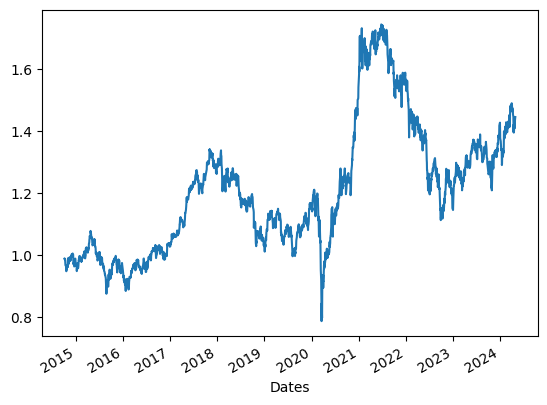

In [21]:
(1+krx_idx['코스피 200'].pct_change().loc['2014-10-02':]).cumprod().plot()

# backtesting

In [22]:
adjprc=data_SSC_nodup['AdjPrc'].unstack()
adjprc=adjprc.astype(float)

In [583]:
data_path='../data/output/prob_out/'
# file_name='multilayer_factor_rolling_v1.0_2024-03-29_ver0.1.csv'
file_name='prob_res_2014-01-29_2024-02-29_ver0.1.csv'
# hyungshin.lee/data/output/prob_out/prob_res_2013-01-25_2023-08-31.csv
raw_prob=pd.read_csv(data_path+file_name, index_col=0)

# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)

In [584]:
raw_prob.index

Index(['2017-01-06', '2017-01-13', '2017-01-20', '2017-01-26', '2017-02-03',
       '2017-02-10', '2017-02-17', '2017-02-24', '2017-03-03', '2017-03-10',
       ...
       '2023-12-28', '2024-01-05', '2024-01-12', '2024-01-19', '2024-01-26',
       '2024-02-02', '2024-02-08', '2024-02-16', '2024-02-23', '2024-02-29'],
      dtype='object', name='Dates', length=373)

In [585]:
raw_prob

,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A175330,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-06,0.202009,0.213429,0.206594,0.222489,0.192793,0.206674,0.187661,0.211250,0.209440,0.161159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.199454,0.212383,0.202911,0.221826,0.198615,0.207258,0.184772,0.210928,0.205835,0.161247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-20,0.197967,0.213269,0.202864,0.222847,0.200520,0.205254,0.183336,0.212298,0.204900,0.166422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-26,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.200100,0.211997,0.198505,0.221687,0.204146,0.204283,0.172575,0.211672,0.204807,0.174064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,NaN,NaN,NaN,0.020217,0.025818,0.016344,NaN,0.022183,0.024446,NaN,...,0.023859,0.024005,0.020695,0.027580,0.021532,0.013047,0.021156,0.024797,0.027896,0.023444
2024-02-08,NaN,NaN,NaN,0.020032,0.025980,0.015417,NaN,0.022841,0.023763,NaN,...,0.025390,0.024822,0.021292,0.027748,0.026170,0.016089,0.021723,0.026376,0.028160,0.022096
2024-02-16,NaN,NaN,NaN,0.022642,0.026277,0.015752,NaN,0.023896,0.021194,NaN,...,0.025189,0.024910,0.021007,0.029489,0.033904,0.017759,0.025372,0.026740,0.028355,0.021878


In [25]:
# raw_prob.reset_index(inplace=True)
# raw_prob.set_index(['Dates', 'Symbol'], inplace=True)
# raw_prob=raw_prob.unstack()
# raw_prob.columns=raw_prob.columns.get_level_values(1)

In [26]:
raw_prob.index = pd.to_datetime(raw_prob.index)

<Axes: xlabel='Dates'>

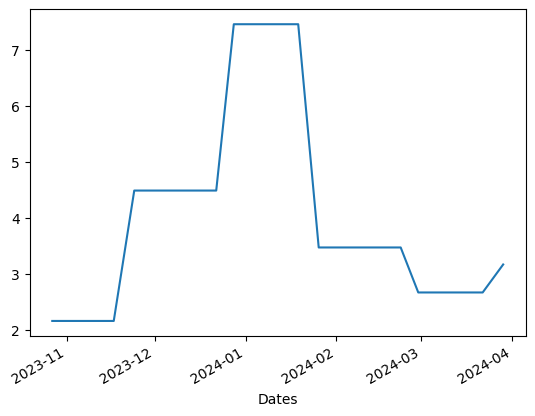

In [27]:
raw_prob.sum(1).plot()

<Axes: xlabel='Dates'>

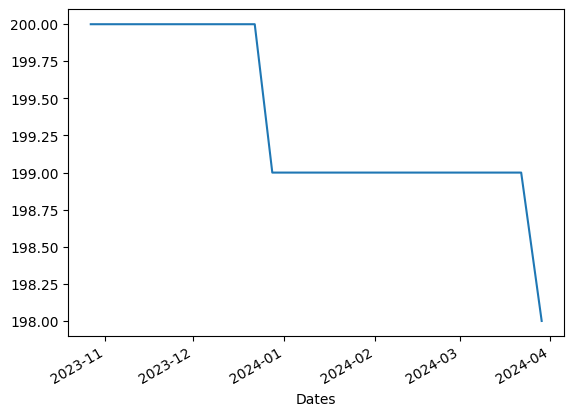

In [28]:
raw_prob.count(1).plot()

<Axes: xlabel='Dates'>

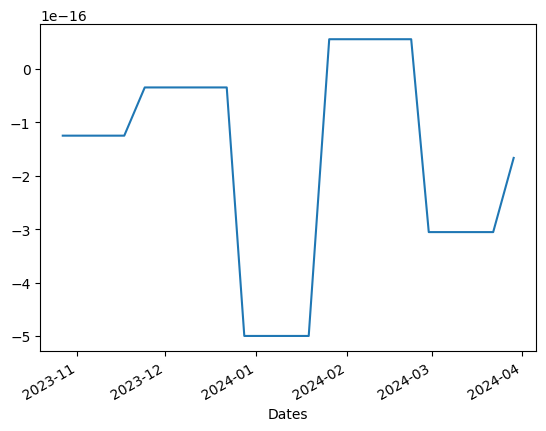

In [29]:
raw_prob.subtract(raw_prob.mean(1), axis=0).sum(1).plot()

In [30]:
# use existing weight with shift1

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [32]:
scaler = StandardScaler()
tempw = scaler.fit_transform(raw_prob.iloc[0].dropna().values.reshape(-1, 1))
temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[0].dropna().index)

In [33]:
temp_w=temp_w/abs(temp_w).sum()

In [34]:
temp_w

,0
A000080,0.001386
A000100,-0.003673
A000120,-0.001209
A000150,0.064959
A000210,0.000123
...,...
A375500,0.002594
A377300,-0.003571
A381970,0.001918
A383220,-0.002078


In [35]:
raw_prob.iloc[-1].sort_values().dropna()

A015760    0.004021
A036460    0.004226
A000880    0.004245
A267260    0.004838
A005490    0.005699
             ...   
A383220    0.017457
A001440    0.017489
A020150    0.017836
A032350    0.025476
A003620    1.000000
Name: 2024-03-29 00:00:00, Length: 198, dtype: float64

In [36]:
ls_weight_ls = []
len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob.iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[i].dropna().index)
    
    # remove top bottom +/- 2stdev
    temp_w[temp_w>(temp_w.mean()+2*temp_w.std())]=2
    temp_w[temp_w<(temp_w.mean()-2*temp_w.std())]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w=temp_w/abs(temp_w).sum()
    len_ls.append(len(temp_w[temp_w>0].dropna()))
    ls_weight_ls.append(temp_w)
    

<Axes: >

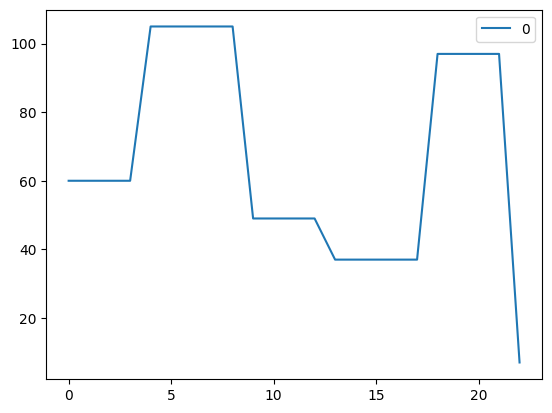

In [37]:
pd.DataFrame(len_ls).plot()

In [38]:
ls_w=pd.concat(ls_weight_ls, axis=1).T
ls_w.index=raw_prob.index

<Axes: >

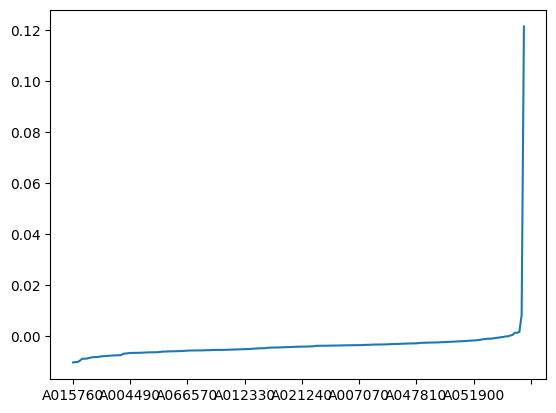

In [39]:
ls_w.iloc[-1].sort_values().dropna().plot()

In [40]:
temp_ls_w=ls_w.copy()
temp_ls_w.loc[:, 'A001570']=0

In [41]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

In [42]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

In [43]:
long_w=ls_w[temp_ls_w>0]
short_w=ls_w[temp_ls_w<0]


In [44]:
ew_long=long_w.copy()
ew_short=short_w.copy()

In [45]:
ew_long[ew_long>0]=1
ew_short[ew_short<0]=-1

In [46]:
ew_long=ew_long.div(ew_long.count(1), axis=0)
ew_short=ew_short.div(ew_short.count(1), axis=0)

<Axes: xlabel='Dates'>

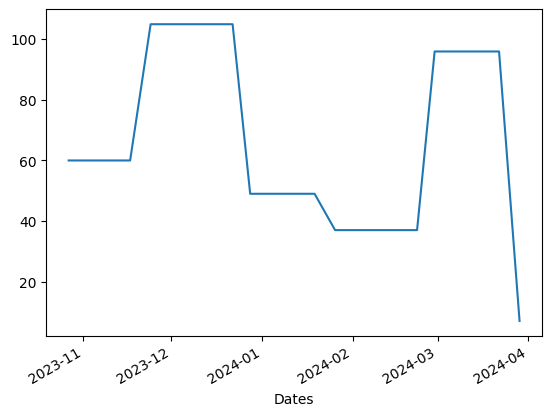

In [47]:
ew_long.count(1).plot()

In [48]:
long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2

In [49]:
ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)

# LS results

In [50]:
long_w.loc['2023-06-01': '2023-12-01', 'A001570'].fillna(0)

Dates
2023-10-27    0.0
2023-11-03    0.0
2023-11-10    0.0
2023-11-17    0.0
2023-11-24    0.0
2023-12-01    0.0
Name: A001570, dtype: float64

/tmp/ipykernel_4525/1600025215.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()


<Axes: xlabel='Dates'>

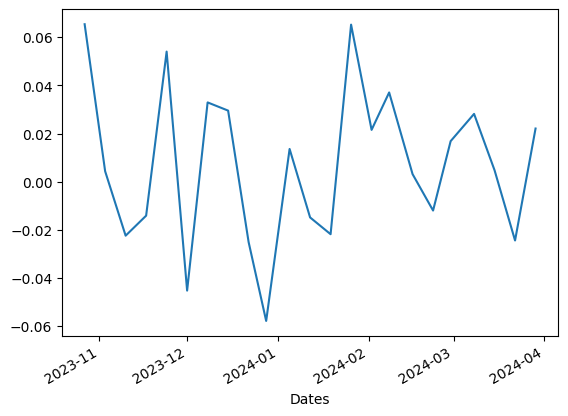

In [51]:
adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()

In [52]:
ls_w.loc['2023-06-01':].index

DatetimeIndex(['2023-10-27', '2023-11-03', '2023-11-10', '2023-11-17',
               '2023-11-24', '2023-12-01', '2023-12-08', '2023-12-15',
               '2023-12-22', '2023-12-28', '2024-01-05', '2024-01-12',
               '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-08',
               '2024-02-16', '2024-02-23', '2024-02-29', '2024-03-08',
               '2024-03-15', '2024-03-22', '2024-03-29'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [53]:
adjprc.loc[ls_w.loc['2023-06-01':].index, 'A001570'].pct_change()

Dates
2023-10-27         NaN
2023-11-03    0.009868
2023-11-10    0.090119
2023-11-17   -0.023904
2023-11-24    0.074490
2023-12-01    0.163343
2023-12-08   -0.053061
2023-12-15   -0.008621
2023-12-22   -0.052174
2023-12-28    0.001835
2024-01-05   -0.045788
2024-01-12   -0.043186
2024-01-19   -0.099298
2024-01-26   -0.109131
2024-02-02    0.007500
2024-02-08    0.040943
2024-02-16    0.133492
2024-02-23   -0.044164
2024-02-29    0.061606
2024-03-08    0.323316
2024-03-15   -0.010180
2024-03-22   -0.050633
2024-03-29   -0.036667
Name: A001570, dtype: float64

In [54]:
idx_ret['A001570'].dropna()

Dates
2023-11-03    0.0
2023-11-10    0.0
2023-11-17   -0.0
2023-11-24    0.0
2023-12-01    0.0
2023-12-08   -0.0
2023-12-15   -0.0
2023-12-22   -0.0
2023-12-28    0.0
2024-01-05   -0.0
2024-01-12   -0.0
2024-01-19   -0.0
2024-01-26   -0.0
2024-02-02    0.0
2024-02-08    0.0
2024-02-16    0.0
2024-02-23   -0.0
2024-02-29    0.0
2024-03-08    0.0
2024-03-15   -0.0
2024-03-22   -0.0
2024-03-29   -0.0
Name: A001570, dtype: float64

<Axes: xlabel='Dates'>

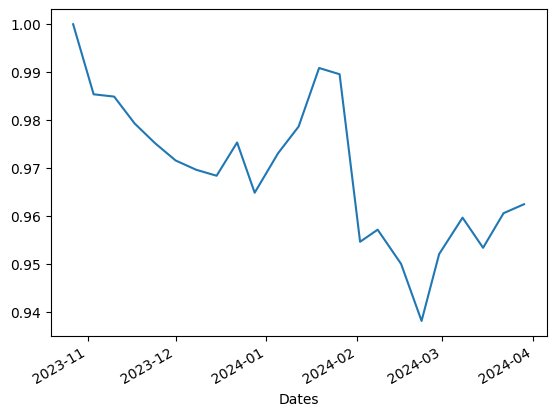

In [55]:
# raw long short 
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

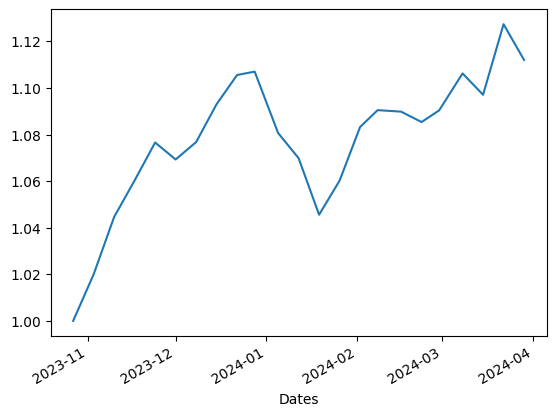

In [56]:
# raw long
(1+long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

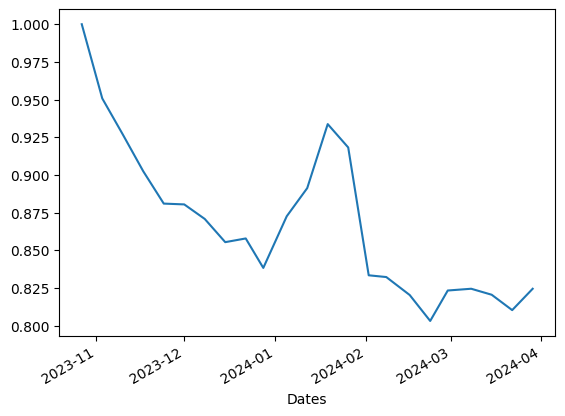

In [57]:
# raw short
(1+short_idx_ret.sum(1)).cumprod().plot()

In [58]:
# equal weight long short

<Axes: xlabel='Dates'>

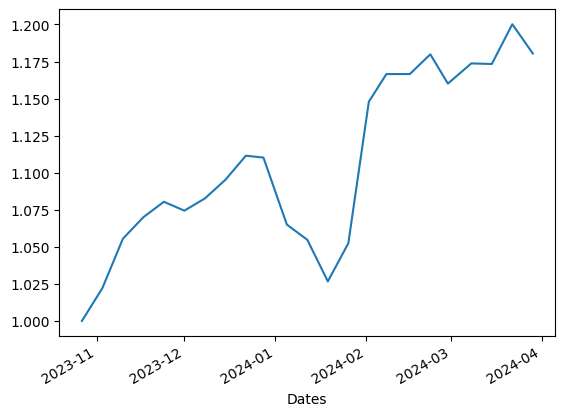

In [59]:
(1+ew_long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

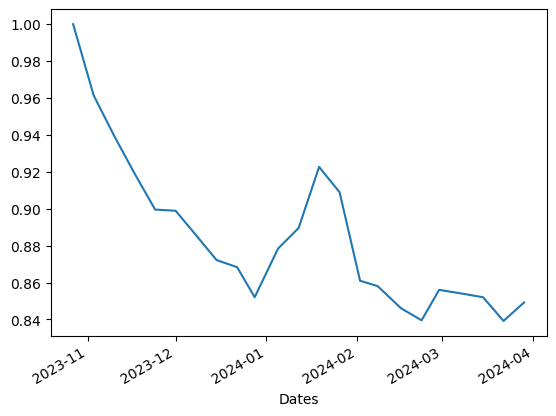

In [60]:
(1+ew_short_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

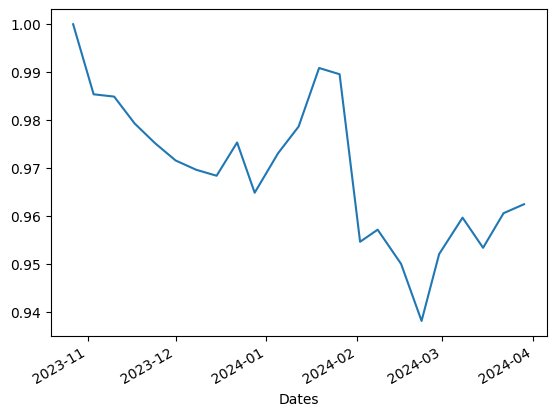

In [61]:
# remove top and bottom
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

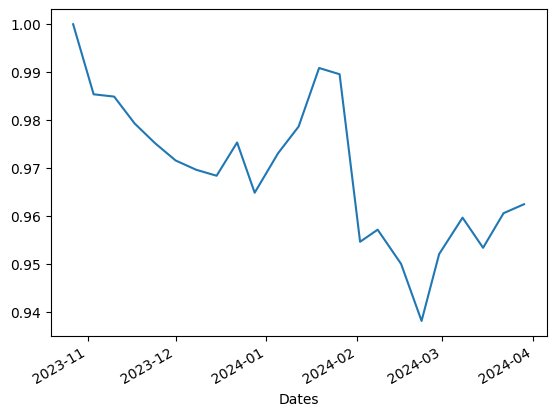

In [62]:
# remove in the middle
(1+idx_ret.sum(1)).cumprod().plot()

In [63]:
k100ls_entire = perf.analyze_performance(idx_ret.sum(1),
                                     weights = daily_weight,
                                     model_name = 'k100ls')

NameError: name 'daily_weight' is not defined

In [66]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [70]:
len(data_COM_nodup['KC_Industry'].unique())

30

In [71]:
len(data_COM_nodup['FG_IndustryGroup27'].unique())

28

In [72]:
len(data_COM_nodup['FG_Sector_Idx'].unique())

11

In [73]:
len(data_COM_nodup['FG_IndustryGroup_Idx'].unique())

26

In [74]:
len(data_COM_nodup['FG_Industry_Idx'].unique())

61

# k100 universe result

In [75]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [76]:
k100comp=data_COM_nodup['KOSPI100YN'].to_frame().unstack()

In [77]:
k100comp=k100comp[k100comp=='Y']

In [78]:
k100comp.count(1)

Dates
2014-09-01    100
2014-09-02    100
2014-09-03    100
2014-09-04    100
2014-09-05    100
             ... 
2024-03-25    100
2024-03-26    100
2024-03-27    100
2024-03-28    100
2024-03-29    100
Length: 2356, dtype: int64

In [79]:
k100comp[k100comp=='Y']=1

In [80]:
k100comp.sum(1)

Dates
2014-09-01    100
2014-09-02    100
2014-09-03    100
2014-09-04    100
2014-09-05    100
             ... 
2024-03-25    100
2024-03-26    100
2024-03-27    100
2024-03-28    100
2024-03-29    100
Length: 2356, dtype: object

In [81]:
k100comp=k100comp[k100comp>0].dropna(how='all', axis=1)

In [82]:
k100comp.columns=k100comp.columns.get_level_values(1)

In [83]:
k100comp.columns

Index(['A000030', 'A000080', 'A000100', 'A000120', 'A000150', 'A000210',
       'A000270', 'A000660', 'A000670', 'A000720',
       ...
       'A323410', 'A326030', 'A329180', 'A352820', 'A361610', 'A373220',
       'A377300', 'A383220', 'A402340', 'A450080'],
      dtype='object', name='Symbol', length=149)

In [84]:
k100_col=set(raw_prob.columns).intersection(k100comp.columns)

In [85]:
k100_col=list(k100_col)

In [86]:
k100_ls_weight_ls = []
k100_len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob[k100_col].iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob[k100_col].iloc[i].dropna().index)

    temp_w2=temp_w.copy()
    temp_w2.loc['A001570']=0

    # remove top bottom +/- 2stdev
    temp_w[temp_w>temp_w.mean()+2*temp_w.std()]=2
    temp_w[temp_w<temp_w.mean()-2*temp_w.std()]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w2=temp_w2/abs(temp_w2).sum()
    k100_len_ls.append(len(temp_w2[temp_w2>0].dropna()))
    k100_ls_weight_ls.append(temp_w2)

In [87]:
k100_ls_w=pd.concat(k100_ls_weight_ls, axis=1).T
k100_ls_w.index=raw_prob.index

In [88]:
k100_ls_w.sum(1)[k100_ls_w.sum(1)<-0.05]

Series([], dtype: float64)

In [89]:
k100_ls_w=k100_ls_w.subtract(k100_ls_w.mean(1), axis=0)

In [90]:
k100_ls_w[k100_ls_w>0]=k100_ls_w[k100_ls_w>0].div(k100_ls_w[k100_ls_w>0].sum(1)*2, axis=0)
k100_ls_w[k100_ls_w<0]=k100_ls_w[k100_ls_w<0].div(k100_ls_w[k100_ls_w<0].sum(1)*-2, axis=0)

<Axes: >

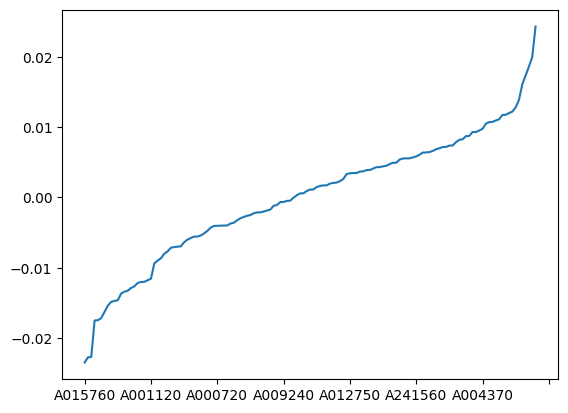

In [91]:
k100_ls_w.iloc[-1].sort_values().plot()

In [92]:
k100_idx_ret=adjprc.loc[k100_ls_w.index, k100_ls_w.columns].pct_change()*k100_ls_w.shift(1)

In [93]:
k100_ls_w

,A161390,A016360,A012330,A036460,A028050,A008930,A000720,A009240,A010140,A032830,...,A138040,A000150,A009150,A035420,A373220,A207940,A033780,A000100,A282330,A028260
Dates,,,,,,,,,,,,,,,,,,,,,
2023-10-27,-0.002000,0.000031,-0.004353,0.037536,-0.003763,-0.007419,0.000759,-0.006997,-0.008969,0.003475,...,0.001875,0.079679,-0.009161,-0.007731,-0.005275,-0.001730,-0.004579,-0.005563,-0.000507,-0.000649
2023-11-03,-0.002000,0.000031,-0.004353,0.037536,-0.003763,-0.007419,0.000759,-0.006997,-0.008969,0.003475,...,0.001875,0.079679,-0.009161,-0.007731,-0.005275,-0.001730,-0.004579,-0.005563,-0.000507,-0.000649
2023-11-10,-0.002000,0.000031,-0.004353,0.037536,-0.003763,-0.007419,0.000759,-0.006997,-0.008969,0.003475,...,0.001875,0.079679,-0.009161,-0.007731,-0.005275,-0.001730,-0.004579,-0.005563,-0.000507,-0.000649
2023-11-17,-0.002000,0.000031,-0.004353,0.037536,-0.003763,-0.007419,0.000759,-0.006997,-0.008969,0.003475,...,0.001875,0.079679,-0.009161,-0.007731,-0.005275,-0.001730,-0.004579,-0.005563,-0.000507,-0.000649
2023-11-24,0.004123,0.002783,-0.006361,0.006234,0.003412,-0.000015,-0.000355,-0.007241,-0.009889,0.004998,...,0.007938,0.011283,-0.006128,-0.011560,-0.022435,-0.004128,-0.001444,-0.004598,0.004198,-0.001182
2023-12-01,0.004123,0.002783,-0.006361,0.006234,0.003412,-0.000015,-0.000355,-0.007241,-0.009889,0.004998,...,0.007938,0.011283,-0.006128,-0.011560,-0.022435,-0.004128,-0.001444,-0.004598,0.004198,-0.001182
2023-12-08,0.004123,0.002783,-0.006361,0.006234,0.003412,-0.000015,-0.000355,-0.007241,-0.009889,0.004998,...,0.007938,0.011283,-0.006128,-0.011560,-0.022435,-0.004128,-0.001444,-0.004598,0.004198,-0.001182
2023-12-15,0.004123,0.002783,-0.006361,0.006234,0.003412,-0.000015,-0.000355,-0.007241,-0.009889,0.004998,...,0.007938,0.011283,-0.006128,-0.011560,-0.022435,-0.004128,-0.001444,-0.004598,0.004198,-0.001182
2023-12-22,0.004123,0.002783,-0.006361,0.006234,0.003412,-0.000015,-0.000355,-0.007241,-0.009889,0.004998,...,0.007938,0.011283,-0.006128,-0.011560,-0.022435,-0.004128,-0.001444,-0.004598,0.004198,-0.001182


In [94]:
rebal_dates = proc.find_entire_rebalancing_dates(k100_ls_w.index)


lack of the beginning part of data  2023-09-30 00:00:00 2023-10-27 00:00:00
expected date is not in inner dates 2023-10-31 00:00:00
2023-10-31 00:00:00 2023-10-27 00:00:00
expected date is not in inner dates 2023-11-30 00:00:00
2023-11-30 00:00:00 2023-11-24 00:00:00
expected date is not in inner dates 2023-12-31 00:00:00
2023-12-31 00:00:00 2023-12-28 00:00:00
expected date is not in inner dates 2024-01-31 00:00:00
2024-01-31 00:00:00 2024-01-26 00:00:00


In [95]:
rebal_dates

DatetimeIndex(['2023-10-27', '2023-11-24', '2023-12-28', '2024-01-26',
               '2024-02-29', '2024-03-29'],
              dtype='datetime64[ns]', freq=None)

In [96]:
daily_ret_cost=perf.compute_daily_ret(adjprc, k100_ls_w, rebal_dates)

<Axes: xlabel='Dates'>

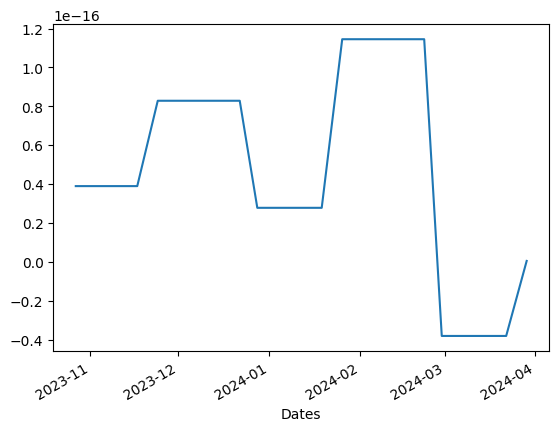

In [97]:
k100_ls_w.fillna(0).sum(1).plot()

In [98]:
init_value=10**9
cost=0.002
daily_quantity=pd.DataFrame(None, index=adjprc.loc[rebal_dates[0]:rebal_dates[-1]].index, columns=k100_ls_w.columns)
temp_price=adjprc.loc[rebal_dates[0]:rebal_dates[-1], k100_ls_w.columns].copy()
rebal_weights=k100_ls_w.fillna(0).copy()
ret_ls=[]

ls_port=(rebal_weights.iloc[0]<0).sum()>0

for idx, date in enumerate(rebal_dates):
    if date == rebal_dates[0]:
        daily_quantity.loc[date]=init_value*rebal_weights.loc[date]/temp_price.loc[date]
        
    else:
        prev_idx=temp_price.index.get_loc(date)-1
        prev_date=temp_price.index[prev_idx]
                
        # fill monthly quantity
        daily_quantity.loc[:prev_date]=daily_quantity.loc[:prev_date].ffill()
        
        # find eom nav
        # for long short portfolio
        # prev date on quantity has an effect of shift(1)
        if ls_port:
            mid_value=(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum() \
                      - (daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()
        else:
            mid_value=(daily_quantity.loc[prev_date]*temp_price.loc[date]).sum()
        
        # find quantity
        daily_quantity.loc[date]=mid_value*rebal_weights.loc[date]/temp_price.loc[date]
    # print(date, mid_value)
    
if ls_port:
    nav1=(daily_quantity[daily_quantity>0]*temp_price).sum(1)
    nav2=(daily_quantity[daily_quantity<0]*temp_price).sum(1)
    daily_ret=nav1.pct_change()-nav2.pct_change()
else:
    nav=daily_quantity*temp_price
    daily_ret=nav.pct_change()

# apply cost
w_diff = abs(rebal_weights.diff(1))
daily_ret.loc[w_diff.index] = daily_ret.loc[w_diff.index] - w_diff.sum(axis=1) * cost

In [99]:
k100_ls_w.index

DatetimeIndex(['2023-10-27', '2023-11-03', '2023-11-10', '2023-11-17',
               '2023-11-24', '2023-12-01', '2023-12-08', '2023-12-15',
               '2023-12-22', '2023-12-28', '2024-01-05', '2024-01-12',
               '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-08',
               '2024-02-16', '2024-02-23', '2024-02-29', '2024-03-08',
               '2024-03-15', '2024-03-22', '2024-03-29'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [100]:
check_date='2017-02-10'
check_nav=daily_quantity.loc[check_date]*temp_price.loc[check_date]
check_nav1=check_nav[check_nav>0]
check_nav2=check_nav[check_nav<0]

KeyError: '2017-02-10'

In [ ]:
check_nav1.sum()-check_nav2.sum()

In [ ]:
check_nav=(daily_quantity*temp_price)
check_nav1=check_nav[check_nav>0]
check_nav2=check_nav[check_nav<0]

In [ ]:
(1+(check_nav1.sum(1)-check_nav2.sum(1)).pct_change()).cumprod().plot()

In [ ]:
check_nav3=check_nav1.sum(1)-check_nav2.sum(1)


In [101]:
check_nav1.pct_change().loc['2023-06-30'].sort_values()

NameError: name 'check_nav1' is not defined

In [102]:
check_nav2.pct_change().loc['2023-06-30'].sort_values()

NameError: name 'check_nav2' is not defined

In [103]:
check_nav1.loc['2023-06-26':'2023-07-03', 'A383220']

NameError: name 'check_nav1' is not defined

In [104]:
check_nav2.loc['2023-06-26':'2023-07-03', 'A383220']

NameError: name 'check_nav2' is not defined

In [105]:
(check_nav1.sum(1)-check_nav2.sum(1)).pct_change().plot()

NameError: name 'check_nav1' is not defined

In [ ]:
nav_ret=(check_nav1.sum(1)-check_nav2.sum(1)).pct_change()

In [ ]:
nav_ret[nav_ret<-.2]

In [ ]:
check_nav1.sum(1).loc['2023-06-25':'2023-07-03']

In [ ]:
temp_nav=daily_quantity.loc['2023-06-30']*temp_price.loc['2023-06-30']
temp_nav[temp_nav>0].sum() - temp_nav[temp_nav<0].sum()

In [ ]:
daily_quantity.loc['2023-06-25':'2023-07-03']

In [ ]:
check_nav2.sum(1).loc['2023-06-25':'2023-07-03']

In [ ]:
pos_w=k100_ls_w[k100_ls_w>0].sum(1)
neg_w=k100_ls_w[k100_ls_w<0].sum(1)

In [ ]:
neg_w.plot()

In [ ]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum()

In [ ]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()

In [ ]:
rebal_weights.iloc[0]

In [ ]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum()

In [ ]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()

In [ ]:
(1+ (nav1.pct_change()-nav2.pct_change())).cumprod()

In [ ]:
nav1.pct_change()

In [ ]:
(1+daily_ret).cumprod().plot()

In [ ]:
nav.pct_change()

In [ ]:
(1+daily_ret.sum(1)).cumprod()

In [ ]:
(rebal_weights<0).sum(1)>0

In [ ]:
daily_weight=pd.DataFrame(None, columns=k100_ls_w.columns, index=adjprc.loc[k100_ls_w.index[0]:k100_ls_w.index[-1]].index)

In [ ]:
daily_weight.loc[k100_ls_w.index]=k100_ls_w.fillna(0)

In [ ]:
daily_weight=daily_weight.ffill()

In [ ]:
daily_ret_v2=(daily_weight.shift(1)*adjprc.pct_change().loc[k100_ls_w.index[0]:k100_ls_w.index[-1]]).sum(1)

In [ ]:
daily_ret_v2.plot()

In [ ]:
(1+daily_ret_v2).cumprod().plot()

In [ ]:
(1+k100_idx_ret.sum(1)).cumprod().plot()

In [ ]:
(1+k100_idx_ret.loc['2023-01-01':].sum(1)).cumprod().plot()

In [ ]:
idx_daily_cost, idx_cum_cost=perf.apply_trading_cost(daily_ret_v2, k100_ls_w)

In [ ]:
idx_cum_cost.plot()

In [ ]:
k100ls_entire = perf.analyze_performance(daily_ret_v2,
                                     weights = daily_weight,
                                     model_name = 'k100ls')

In [ ]:
k100ls_entire

In [ ]:
k100ls_2023 = perf.analyze_performance(daily_ret_v2.loc['2023-01-01':],
                                       weights = daily_weight,
                                       model_name = 'k100ls2023')

In [ ]:
k100ls_2023

In [ ]:
k100ls_2024 = perf.analyze_performance(daily_ret_v2.loc['2024-01-01':],
                                       weights = daily_weight,
                                       model_name = 'k100ls2023')

In [ ]:
k100ls_2024

# optimize port

### how to optimize 
#### compare with market weight 
#### input: k200 weight, score, vol(return)


In [106]:
from scipy.optimize import minimize
import numpy as np

In [301]:
bmw=k200_df['idx_weight'].unstack()

In [108]:
adjprc.pct_change(60)

/tmp/ipykernel_4525/4222830641.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change(60)


Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A460860,A462520,A465770,A900030,A900050,A900140,A950010,A950070,A950100,A950210
Dates,,,,,,,,,,,,,,,,,,,,,
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,NaN,-0.036290,0.0,1.943820,-0.038117,0.0,0.022857,-0.118790,NaN,0.184755,...,-0.130961,-0.135731,-0.359014,NaN,0.0,0.135496,0.0,NaN,0.0,-0.050214
2024-03-26,NaN,-0.042169,0.0,2.026316,-0.037373,0.0,0.052857,-0.111349,NaN,0.164425,...,-0.117827,-0.130435,-0.308511,NaN,0.0,0.202358,0.0,NaN,0.0,-0.058252
2024-03-27,NaN,-0.046371,0.0,1.927746,-0.044218,0.0,0.049419,-0.061364,NaN,0.123711,...,-0.062041,-0.132048,-0.301626,NaN,0.0,0.189824,0.0,NaN,0.0,-0.094930


In [109]:
k200_df.index.get_level_values(0).unique()[k200_df.index.get_level_values(0).unique()>'2021-12-22']

DatetimeIndex(['2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07',
               ...
               '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
               '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30',
               '2024-05-02', '2024-05-03'],
              dtype='datetime64[ns]', name='Dates', length=580, freq=None)

In [567]:
ls_w.index

DatetimeIndex(['2023-10-27', '2023-11-03', '2023-11-10', '2023-11-17',
               '2023-11-24', '2023-12-01', '2023-12-08', '2023-12-15',
               '2023-12-22', '2023-12-28', '2024-01-05', '2024-01-12',
               '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-08',
               '2024-02-16', '2024-02-23', '2024-02-29', '2024-03-08',
               '2024-03-15', '2024-03-22', '2024-03-29'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [110]:
comm_dates=ls_w.index.intersection(k200_df.index.get_level_values(0).unique())
rebal_dates = proc.find_entire_rebalancing_dates(comm_dates)

lack of the beginning part of data  2023-09-30 00:00:00 2023-10-27 00:00:00
expected date is not in inner dates 2023-10-31 00:00:00
2023-10-31 00:00:00 2023-10-27 00:00:00
expected date is not in inner dates 2023-11-30 00:00:00
2023-11-30 00:00:00 2023-11-24 00:00:00
expected date is not in inner dates 2023-12-31 00:00:00
2023-12-31 00:00:00 2023-12-28 00:00:00
expected date is not in inner dates 2024-01-31 00:00:00
2024-01-31 00:00:00 2024-01-26 00:00:00


In [111]:
rebal_dates

DatetimeIndex(['2023-10-27', '2023-11-24', '2023-12-28', '2024-01-26',
               '2024-02-29', '2024-03-29'],
              dtype='datetime64[ns]', freq=None)

In [112]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A352820,A361610,A373220,A375500,A377300,A381970,A383220,A383800,A402340,A450080
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,NaN,NaN,NaN,NaN,0.05,0.36,0.12,NaN,0.08,0.05,...,0.31,0.14,1.10,0.09,0.20,NaN,0.08,NaN,0.63,0.12
2024-04-29,NaN,NaN,NaN,NaN,0.05,0.37,0.11,NaN,0.09,0.05,...,0.31,0.14,1.11,0.09,0.20,NaN,0.09,NaN,0.61,0.12
2024-04-30,NaN,NaN,NaN,NaN,0.05,0.36,0.11,NaN,0.09,0.05,...,0.31,0.13,1.14,0.09,0.20,NaN,0.09,NaN,0.59,0.11


In [113]:
ls_w.iloc[-1].describe()

count    198.000000
mean      -0.003692
std        0.009273
min       -0.010386
25%       -0.005800
50%       -0.004178
75%       -0.002919
max        0.121573
Name: 2024-03-29 00:00:00, dtype: float64

In [ ]:
import optuna

In [ ]:


def score_objective(weight, bm_weight, score, cov):
    w_diff=weight-bm_weight
#    print(w_diff)
    port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    adj_sharpe=(w_diff*score).sum() / port_vol
    # print(adj_sharpe)
    return -adj_sharpe
    

def port_objective(trial):
    long_num=trial.suggest_int("long num", -100, -20)
    short_num=trial.suggest_int("short num", 0, 100)
    excess_w=trial.suggest_float("excess weight", 0.02, 0.05)
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        temp_bm_weight=bmw.loc[rebal_date].dropna()
        temp_bm_weight=temp_bm_weight.fillna(0)
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
    
        comm_col=ls_w.loc[rebal_date].dropna().index.intersection(temp_bm_weight.index)
        temp_score=ls_w.loc[rebal_date, comm_col]
    
        sort_score=temp_score.sort_values().dropna().copy()
        temp_score[:]=temp_score.mean()
        if short_num>0:
            temp_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]
    
        temp_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]
        
        # temp_score=temp_score.fillna(0).
        
        temp_cov=adjprc.loc[:rebal_date, comm_col].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
        
        if temp_bm_weight.min() <0:
            temp_score=temp_score+temp_bm_weight.min()+temp_bm_weight.std()
    
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        constraints2 = ({'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight.loc[comm_col])+excess_w})
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(comm_col)))
        
        # Initial guess (equal weights)
        initial_guess = [1 / len(comm_col) for asset in range(len(comm_col))]
        # initial_guess = temp_bm_weight
        
        # Perform the optimization
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight.loc[comm_col], temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=[constraints, constraints2])
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=comm_col, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()
    daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_opt_cumret[-1]

In [ ]:
study=optuna.create_study(direction='maximize')
study.optimize(port_objective, n_trials=30)

In [ ]:
study.best_trials

In [ ]:
def optimize_portfolio(raw_weight, bm_weight, rebal_dates, long_num, short_num, excess_w):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
        temp_bm_weight=temp_bm_weight.fillna(0)
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
    
        comm_col=raw_weight.loc[rebal_date].dropna().index.intersection(temp_bm_weight.index)
        temp_score=raw_weight.loc[rebal_date, comm_col]
    
        sort_score=temp_score.sort_values().dropna().copy()
        temp_score[:]=temp_score.mean()
        if short_num>0:
            temp_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]
    
        temp_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]
        
        # temp_score=temp_score.fillna(0).

        if temp_bm_weight.min() <0:
            temp_score=temp_score+temp_bm_weight.min()+temp_bm_weight.std()
        
        temp_cov=adjprc.loc[:rebal_date, comm_col].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
            
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        constraints2 = ({'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight.loc[comm_col])+excess_w})
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(comm_col)))
        
        # Initial guess (equal weights)
        initial_guess = [1 / len(comm_col) for asset in range(len(comm_col))]
        # initial_guess = temp_bm_weight
        
        # Perform the optimization
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight.loc[comm_col], temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=[constraints, constraints2])
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=comm_col, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()
    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw


In [ ]:
daily_optw=optimize_portfolio(ls_w, bmw, rebal_dates, -75, 30, .03)

In [234]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [121]:
bmw.loc[rebal_dates[-1]]

Symbol
A000030     NaN
A000050     NaN
A000060     NaN
A000070     NaN
A000080    0.05
           ... 
A381970     NaN
A383220    0.09
A383800     NaN
A402340    0.61
A450080    0.12
Name: 2024-03-29 00:00:00, Length: 299, dtype: float64

In [124]:
pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_Sector_Idx'], bmw.loc[rebal_dates[-1]]], axis=1).groupby('FG_Sector_Idx').sum()

,2024-03-29 00:00:00
FG_Sector_Idx,
IT,49.83
경기소비재,9.98
금융,10.91
산업재,10.19
소재,7.23
에너지,2.19
유틸리티,0.69
의료,5.10
통신서비스,1.55


In [236]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [566]:
rebal_dates

DatetimeIndex(['2023-10-27', '2023-11-24', '2023-12-28', '2024-01-26',
               '2024-02-29', '2024-03-29'],
              dtype='datetime64[ns]', freq=None)

In [568]:
def score_objective(weight, bm_weight, score, cov):
    w_diff=abs(weight-bm_weight)
    if w_diff.sum()==0:
        return 0
    try:
        # Check for specific error message before sqrt
        if np.any(np.isnan(np.dot(w_diff.T, np.dot(cov, w_diff)))):
            raise ValueError("Encountered NaN values during portfolio volatility calculation.")
        port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    
    except (ValueError, RuntimeWarning) as e:
        print(w_diff.isin([np.inf, -np.inf]).any().any())
        print(cov.isin([np.inf, -np.inf]).any().any())
        print(np.dot(cov, w_diff))
        print(np.dot(w_diff.T, np.dot(cov, w_diff)))
        print("Warning: Encountered errors during portfolio volatility calculation.")
        print(e)
    
    adj_sharpe=(w_diff*score).sum() / port_vol
    return -adj_sharpe

def handle_missingCol(port_df, bm_df, method='fill'):
    """
        compare given port column and BM column
    """
    if method=='fill':
        missing_cols = set(bm_df.index) - set(port_df.index)
        
        # Add the missing columns to df1 with NaN values
        for col in missing_cols:
            print('missing col: ', col)
            # df1.loc[col] = pd.Series([None] * len(df1), index=df1.index)
            port_df.loc[col]=None
        port_df=port_df.loc[bm_df.index]
        
    elif method=='drop':
        comm_col=raw_weight.loc[rebal_date].dropna().index.intersection(temp_bm_weight.index)
        port_df=port_df[comm_col]
    
    print('port shape: ', port_df.shape)
    return port_df


def convert_lsScore(port_score, short_num, long_num):
    """
        when score is all positive, it convert to the mean of score is 0 so that it can be used in Long/Short       
    """
    # convert into L/S scores
    sort_score=port_score.sort_values().dropna().copy()
    port_score[:]=port_score.mean()
    if short_num>0:
        port_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]

    port_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]       
    port_score=port_score.fillna(0)
    
    return port_score


def create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw):

    # sector constraints variables       
    sector_mapping = {sector: idx for idx, sector in enumerate(temp_bm_sectorw.index)}

    A = np.zeros((len(temp_bm_sectorw), len(temp_bm_stockw)), dtype=int)
    for i, stock in enumerate(temp_bm_stockw.index):
        sector_idx = sector_mapping[temp_bm_stockw.loc[temp_bm_stockw.index == stock, 'FG_Sector_Idx'].iloc[0]]
        A[sector_idx, i] = 1
    
    return A



def optimize_portfolio_(raw_score, bm_weight, rebal_dates, long_num, short_num, excess_stockw, excess_sectorw):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        # slice BM weight
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
#        temp_bm_weight=temp_bm_weight.fillna(0)/
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
        
        # slice port weight
        temp_port_score=handle_missingCol(raw_score.loc[rebal_date], temp_bm_weight)
        temp_port_score=temp_port_score.fillna(0)

        # convert score into long/short score
        temp_score=convert_lsScore(temp_port_score, short_num, long_num)

        # compute covariance
        temp_cov=adjprc.loc[:rebal_date, temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
            
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        const1 = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        const2 = {'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight)+excess_stockw}

        # load sector weight info
        temp_bm_sector=data_COM_nodup.loc[rebal_date, 'FG_Sector_Idx']
        temp_bm_stockw=pd.concat([temp_bm_sector, temp_bm_weight], axis=1).dropna()
        temp_bm_stockw=temp_bm_stockw.loc[temp_port_score.index]
        temp_bm_sectorw=temp_bm_stockw.groupby('FG_Sector_Idx').sum()

        A=create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw)
        const3 = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sectorw.values.flatten()) + excess_sectorw}
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(temp_score.index)))

        constraints=[const1, const2, const3] #+sec_ub+sec_lb

        # Initial guess (equal weights)
        initial_guess = [1 / len(temp_score.index) for asset in range(len(temp_score.index))]
        # initial_guess = temp_bm_weight.values
        
        # Perform the optimization
        print(temp_bm_weight.shape, temp_score.shape, temp_cov.shape)
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight, temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=constraints) # 
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=temp_score.index, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()

    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw


In [569]:
daily_optw=optimize_portfolio_(ls_w, bmw, rebal_dates, -75, 30, .03, .02)

2023-10-27 00:00:00
port shape:  (200,)
(200,) (200,) (200, 200)
2023-11-24 00:00:00
port shape:  (200,)
(200,) (200,) (200, 200)
2023-12-28 00:00:00
missing col:  A450080
port shape:  (200,)
(200,) (200,) (200, 200)
2024-01-26 00:00:00
missing col:  A450080
port shape:  (200,)
(200,) (200,) (200, 200)
2024-02-29 00:00:00
missing col:  A450080
port shape:  (200,)
(200,) (200,) (200, 200)
2024-03-29 00:00:00
missing col:  A022100
missing col:  A450080
port shape:  (200,)
(200,) (200,) (200, 200)


In [561]:
daily_optw.loc[rebal_dates[-1]].sort_values()

Symbol
A383220    9.378823e-13
A004370    1.280131e-12
A026960    1.366022e-12
A271560    1.379377e-12
A111770    1.557914e-12
               ...     
A005380    2.508681e-02
A068270    2.584597e-02
A003620    3.040008e-02
A000660    8.288339e-02
A005930    3.070993e-01
Name: 2024-03-29 00:00:00, Length: 200, dtype: float64

In [547]:
daily_optw.loc[rebal_dates[-1]].sort_values()

Symbol
A329180    2.711510e-14
A012750    2.874830e-14
A004370    2.885166e-14
A383220    3.114265e-14
A271560    3.180735e-14
               ...     
A005380    2.371795e-02
A068270    2.605663e-02
A003620    8.004240e-02
A000660    8.262272e-02
A005930    3.061735e-01
Name: 2024-03-29 00:00:00, Length: 200, dtype: float64

In [562]:
temp_bm_sector_w=pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_Sector_Idx'], 
                            bmw.loc[rebal_dates[-1]].dropna()], axis=1).dropna().groupby('FG_Sector_Idx').sum()

In [563]:
temp_port_sector_w=pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_Sector_Idx'], 
                              daily_optw.loc[rebal_dates[-1]].dropna()], axis=1).dropna().groupby('FG_Sector_Idx').sum()

In [564]:
temp_bm_sector_w.sum(), temp_port_sector_w.sum()

(2024-03-29 00:00:00    99.98
 dtype: float64,
 2024-03-29 00:00:00    1.0
 dtype: float64)

In [558]:
temp_bm_sector_w - temp_port_sector_w*100

,2024-03-29 00:00:00
FG_Sector_Idx,
IT,1.027414
경기소비재,-2.733867
금융,0.086742
산업재,0.110864
소재,-0.240158
에너지,0.005465
유틸리티,0.061651
의료,-0.054403
통신서비스,0.615723


In [565]:
temp_bm_sector_w - temp_port_sector_w*100

,2024-03-29 00:00:00
FG_Sector_Idx,
IT,0.855003
경기소비재,-1.928657
금융,0.128858
산업재,0.026560
소재,-0.207971
에너지,0.030404
유틸리티,0.077916
의료,-0.100181
통신서비스,0.172315


In [401]:
daily_optw.iloc[-1]

Symbol
A000080    1.096702e-02
A000100    6.507671e-03
A000120    9.939912e-04
A000150    2.445108e-03
A000210    3.683050e-11
               ...     
A377300    2.227458e-03
A383220    5.938424e-12
A402340    6.174224e-03
A450080    9.197928e-03
A022100    7.702482e-03
Name: 2024-03-29 00:00:00, Length: 201, dtype: float64

In [311]:
bmstockw=pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           bmw.loc['2024-03-29']], axis=1)
bmstockw=bmstockw.dropna()

In [303]:
bmsecw=pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           bmw.loc['2024-03-29']], axis=1).groupby('FG_Sector_Idx').sum()

In [304]:
temp_bm_sector=bmsecw

In [305]:
temp_bm_sector.dropna()

,2024-03-29 00:00:00
FG_Sector_Idx,
IT,49.83
경기소비재,9.98
금융,10.91
산업재,10.19
소재,7.23
에너지,2.19
유틸리티,0.69
의료,5.10
통신서비스,1.55


In [297]:
sector_mapping = {sector: idx for idx, sector in enumerate(temp_bm_sector.index)}
sector_mapping

{'IT': 0,
 '경기소비재': 1,
 '금융': 2,
 '산업재': 3,
 '소재': 4,
 '에너지': 5,
 '유틸리티': 6,
 '의료': 7,
 '통신서비스': 8,
 '필수소비재': 9}

In [312]:
A = np.zeros((len(temp_bm_sector), len(bmstockw.index)), dtype=int)
for i, stock in enumerate(bmstockw.index):
    sector_idx = sector_mapping[bmstockw.loc[bmstockw.index == stock, 'FG_Sector_Idx'].iloc[0]]
    A[sector_idx, i] = 1


In [ ]:
sector_weights = {sector: np.zeros(len(daily_optw.iloc[0])) for sector in data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'].unique()}
for sector, asset_indices in sector_data.items():
    for idx in asset_indices:
      sector_weights[sector][idx] = 1

# Define sector weight bounds (adjust as needed)
sector_bounds = {sector: (0.2, 0.4) for sector in sector_data.keys()}  # Example: 20% - 40% weight for each sector


In [ ]:
sector_constraint(daily_optw.iloc[0]*100, sector_weights, sector_bounds):

In [191]:
data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'].unique()

array(['IT', '의료', '소재', '경기소비재', '산업재', '금융', '에너지', '유틸리티', '필수소비재',
       '통신서비스', None], dtype=object)

In [214]:
daily_optw.iloc[0].sum(), daily_optw.iloc[-1].sum()

(1.002255837762164, 1.0000607709597762)

In [263]:
pd.concat([data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'], 
           daily_optw.iloc[0]*100, bmw.loc['2024-02-29']], axis=1).groupby('FG_Sector_Idx').sum().diff(axis=1).abs().sum()

2024-02-29 00:00:00     0.000000
2024-02-29 00:00:00    11.867857
dtype: float64

In [272]:
pd.concat([data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'], 
           daily_optw.iloc[0]*100, bmw.loc['2024-02-29']], axis=1).groupby('FG_Sector_Idx').sum().diff(axis=1).abs().sum()

2024-02-29 00:00:00     0.000000
2024-02-29 00:00:00    13.576996
dtype: float64

In [265]:
pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           daily_optw.iloc[-1]*100, bmw.loc['2024-03-29']], axis=1).groupby('FG_Sector_Idx').sum().diff(axis=1).abs().sum()

2024-03-29 00:00:00    0.000000
2024-03-29 00:00:00    7.026094
dtype: float64

In [273]:
pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           daily_optw.iloc[-1]*100, bmw.loc['2024-03-29']], axis=1).groupby('FG_Sector_Idx').sum().diff(axis=1).abs().sum()

2024-03-29 00:00:00    0.000000
2024-03-29 00:00:00    7.639314
dtype: float64

In [219]:
np.abs(pd.concat([data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'], 
                  daily_optw.iloc[-1]], 
                 axis=1).groupby('FG_Sector_Idx').sum()- pd.concat([data_COM_nodup.loc['2024-02-29', 'FG_Sector_Idx'], 
                                                                    bmw.loc['2024-03-29']/100], 
                                                                   axis=1).groupby('FG_Sector_Idx').sum()).sum()

2024-03-29 00:00:00    0.250981
dtype: float64

In [195]:
bmsecw=pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           bmw.loc['2024-03-29']], axis=1).groupby('FG_Sector_Idx').sum()

In [279]:
bmsecw.values.flatten()

array([49.83,  9.98, 10.91, 10.19,  7.23,  2.19,  0.69,  5.1 ,  1.55,
        2.31])

In [200]:
pd.concat([data_COM_nodup.loc['2024-03-29', 'FG_Sector_Idx'], 
           bmw.loc['2024-03-29']], axis=1).dropna()

,FG_Sector_Idx,2024-03-29 00:00:00
Symbol,,
A005930,IT,31.53
A373220,IT,1.12
A000660,IT,8.32
A207940,의료,1.06
A051910,소재,1.63
...,...,...
A004490,경기소비재,0.05
A001680,필수소비재,0.03
A105630,경기소비재,0.02


<Axes: xlabel='Dates'>

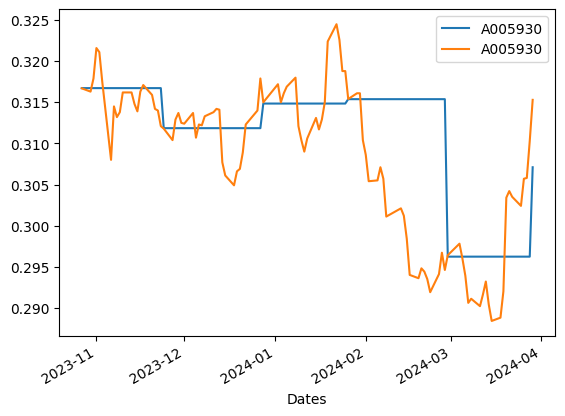

In [573]:
pd.concat([daily_optw['A005930'], (bmw.loc[daily_optw.index, 'A005930']/100)], axis=1).plot()

<Axes: xlabel='Dates'>

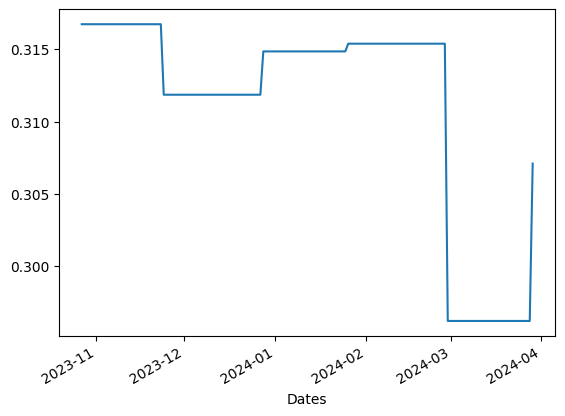

In [575]:
daily_optw['A005930'].plot()

In [ ]:
daily_optw[daily_optw>0].count(1).plot()

In [ ]:
daily_optw=daily_optw.drop(columns=['A003620', 'A137310'])

In [ ]:
daily_optw=daily_optw.div(daily_optw.sum(1), axis=0)

In [ ]:
daily_optw.to_csv('../data/output/weight/202403weight.csv')

In [ ]:
daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw

In [ ]:
daily_optret.sum(1)

In [ ]:
daily_opt_cumret=(1+daily_optret.sum(1)).cumprod()

In [ ]:
daily_opt_cumret

In [ ]:
excess_ret=(daily_optret.sum(1)-krx_idx['코스피 200'].pct_change().loc[daily_optw.index])

In [ ]:
(1+excess_ret).cumprod().plot()

In [ ]:
bm_cumret=(1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()

In [ ]:
pd.concat([daily_opt_cumret, bm_cumret], axis=1).plot()

In [ ]:
# 70
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[daily_optw.index, 
                                                                        daily_optw.columns], 
                                                                        daily_optw,
                                                                        cost=0.002)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()], axis=1).plot()

In [ ]:
a

In [ ]:
daily_optw.iloc[-1].sort_values(ascending=False).loc[['A005930', 'A000660']]

In [ ]:
adjprc.loc['2023-12-25':'2024-01-02'].index

In [ ]:
recent_date='2023-12-28'
recentw=pd.DataFrame(None, index=adjprc.loc[recent_date:].index, columns=daily_optw.columns)

In [ ]:
recentw.loc[recent_date]=daily_optw.iloc[-1]

In [ ]:
recentw=recentw.ffill()

In [ ]:
recent_ret=recentw*adjprc.pct_change().loc[recentw.index, recentw.columns]

In [ ]:
(1+pd.concat([recent_ret.sum(1), krx_idx['코스피 200'].pct_change().loc[recent_date:]], axis=1)).cumprod().plot()

In [ ]:
optw_df.sort_values('opt_w')

In [ ]:
(optw_df['opt_w']-temp_bm_weight).sort_values()

In [ ]:
temp_bm_weight.sort_values()

# sector neutral


### 1. (use selection only) use top score stocks only then allocate weight proportion to the actual market cap
####  if no stock is selected in a sector then follow BM 

### 2. (use selection and score) set boundary of tilt amount and do optimization using score

### 3. (use BM and score) use entire index and tilting using optimization

In [ ]:
data_SSC_nodup.columns

In [ ]:
data_COM_nodup.columns

In [ ]:
temp_com=data_COM_nodup[['KSECapSize', 'FG_Sector_Idx', 'KOSPI200YN']].copy()

In [ ]:
temp_ssc=data_SSC_nodup[['MktCap']].copy()

In [ ]:
bm_mktcap=pd.concat([temp_com, temp_ssc], axis=1)

In [ ]:
bm_mktcap

In [ ]:
bm_mktcap=bm_mktcap[bm_mktcap['KOSPI200YN']=='Y']

In [ ]:
bm_mktcap['MktCap']=bm_mktcap['MktCap'].astype(float)


In [ ]:
bm_mktcap

In [ ]:
bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum('MktCap')

In [ ]:
# bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()

In [ ]:

bm_sector_weight=bm_sector_cap /bm_mktcap.groupby(['Dates']).sum('MKtCap')

In [ ]:
# temp_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')/daily_sector_weight.groupby(['Dates']).sum()

In [ ]:
bm_sector=bm_mktcap['FG_Sector_Idx'].copy()
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'FG_Sector_Idx'], inplace=True)
bm_sector=pd.concat([bm_sector, bm_sector_weight], axis=1)
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'Symbol'], inplace=True)

In [ ]:
# daily_sector_weight=temp_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()/temp_mktcap.groupby(['Dates']).sum()

In [ ]:
# daily_sector_weight=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')
# daily_sector_weight=daily_sector_weight/daily_sector_weight.groupby(['Dates']).sum()

## stock selection from k200

In [ ]:
num_selection=75
top_prob_ls = []

for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob=raw_prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection]
    tempw = scaler.fit_transform(top_prob.values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = top_prob.index)
    top_prob_ls.append(temp_w)
    
top_prob_df=pd.concat(top_prob_ls, axis=1)
top_prob_df=top_prob_df.T
top_prob_df.index=raw_prob.index

top_prob_df=top_prob_df.stack().to_frame()
top_prob_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

In [ ]:
cap_prob_df.dropna()

## stock selection from k100

In [ ]:
top_prob_k100_ls = []

k100prob=raw_prob * k100comp.loc[raw_prob.index]

num_selection_k100=50
for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob_k100=k100prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection_k100]
    tempw_k100 = scaler.fit_transform(top_prob_k100.values.reshape(-1, 1))
    tempw_k100 = pd.DataFrame(tempw_k100, index = top_prob_k100.index)
    top_prob_k100_ls.append(tempw_k100)
    
top_prob_k100_df=pd.concat(top_prob_k100_ls, axis=1)
top_prob_k100_df=top_prob_k100_df.T
top_prob_k100_df.index=raw_prob.index

top_prob_k100_df=top_prob_k100_df.stack().to_frame()
top_prob_k100_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_k100_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_k100_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_k100_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

## rebal dates

In [ ]:
sector_dates=cap_prob_df.dropna().index.get_level_values(0).unique()
sector_dates=pd.to_datetime(sector_dates)
sector_dates=sector_dates.sort_values()

rebal_dates = proc.find_entire_rebalancing_dates(sector_dates)
rebal_dates

In [ ]:
sector_ls=list(bm_sector['FG_Sector_Idx'].unique())
sector='IT'
given_samsung_weight=.3
sam_w=k200_df[k200_df.index.get_level_values(1)=='A005930']

## sector neutral port with samsung neutral

In [ ]:
weight_ls=[]
for date in rebal_dates:
    print(date)
    temp_sector_cap_prob=cap_prob_df[cap_prob_df.index.get_level_values(0)==date]
    
    sector_weight_ls=[]
    for sector in sector_ls:
        
        # when there is no stock in certain sector then keep all stocks in that missing sector
        if sector not in temp_sector_cap_prob.dropna()['FG_Sector_Idx'].unique():
            print(sector)
            temp_sector_neutral=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]['idx_weight']/100
            sector_weight_ls.append(temp_sector_neutral)
            
        else:
            temp_sector_tilt=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector].dropna()
            # temp_sector_neutral['sector_ew']=1/len(temp_sector_neutral)

            if sector=='IT':
                it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
                it_mktcap=temp_sector_tilt['MktCap'].drop(index='A005930', level='Symbol')
                it_mktcap_ratio=it_mktcap/it_mktcap.sum()*it_leftover
                it_mktcap_ratio.loc[(date, 'A005930')]=given_samsung_weight
                sector_weight_ls.append(it_mktcap_ratio)
            else:
                temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
                sector_weight_ls.append(temp_mktcap_ratio)

    weight_df=pd.concat(sector_weight_ls, axis=0)
    weight_ls.append(weight_df)

In [ ]:
temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]

## smoothing weights

In [ ]:
sector_neutral_weight=pd.concat(weight_ls).unstack().dropna(how='all', axis=0)
sector_neutral_weight=sector_neutral_weight.div(sector_neutral_weight.sum(1), axis=0)

temp_adj=adjprc.loc[sector_neutral_weight.index[0]:sector_neutral_weight.index[-1], sector_neutral_weight.columns].copy()
daily_w=temp_adj.copy()
daily_w.loc[sector_neutral_weight.index]=0
daily_w[daily_w!=0]=None
daily_w.loc[sector_neutral_weight.index]=sector_neutral_weight.fillna(0)
daily_w=daily_w.fillna(method='ffill')

In [ ]:
daily_w.sum(1).plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(temp_adj, 
                                                                        daily_w.shift(1),
                                                                        cost=0.003)

In [ ]:
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_w.index]).cumprod()], axis=1).plot()

## k200 ew port with samsung neutral

In [ ]:
top_prob_unstack=top_prob_df.unstack().copy()
top_prob_unstack.columns=top_prob_unstack.columns.get_level_values(1)

k200_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/75
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/76
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k200_weight_ls.append(temp_top_prob)

# k200 market weight

In [ ]:
temp_top_prob_df=top_prob_df[top_prob_df.index.get_level_values(0).isin(rebal_dates)]

In [ ]:
k200_df.index.get_level_values(0).unique(), top_prob_df.index.get_level_values(0).unique()

In [ ]:
temp_k200_df=k200_df[k200_df.index.isin(temp_top_prob_df.index)]

In [ ]:
temp_k200_df=temp_k200_df['idx_weight'].unstack()

In [ ]:
k200_df_mask=temp_k200_df.copy()
k200_df_mask[k200_df_mask>0]=1

In [ ]:
k200_df_mask

In [ ]:
temp_samw=sam_w[sam_w.index.get_level_values(0).isin(temp_k200_df.index.get_level_values(0))]['idx_weight']
temp_samw.index=temp_samw.index.get_level_values(0)

In [ ]:
temp_k200_df['A005930']=temp_samw

In [ ]:
k200_df_mask.sum(1)

In [ ]:
extra_weight=(100-temp_k200_df.sum(1))/k200_df_mask.sum(1)

In [ ]:
temp_k200_df

In [ ]:
k200_mask_weight=k200_df_mask.multiply(extra_weight, axis=0)

In [ ]:
k200_df_mkw=(k200_mask_weight.fillna(0) + temp_k200_df)

In [ ]:
def convert_rebal_to_daily(rebal_weight, daily_df):   
    daily_w=daily_df.loc[rebal_weight.index[0]:rebal_weight.index[-1], rebal_weight.columns].copy()
    daily_w.loc[rebal_weight.index]=0
    daily_w[daily_w!=0]=None
    daily_w.loc[rebal_weight.index]=rebal_weight.fillna(0)
    daily_w=daily_w.fillna(method='ffill')    
    return daily_w

In [ ]:
k200_weight_df=pd.concat(k200_weight_ls, axis=1).T
# temp_adj=adjprc.loc[k200_weight_df.index[0]:k200_weight_df.index[-1], k200_weight_df.columns].copy()
# k200_daily_w=temp_adj.copy()
# k200_daily_w.loc[k200_weight_df.index]=0
# k200_daily_w[k200_daily_w!=0]=None
# k200_daily_w.loc[k200_weight_df.index]=k200_weight_df.fillna(0)
# k200_daily_w=k200_daily_w.fillna(method='ffill')

In [ ]:
k200_daily_w=convert_rebal_to_daily(k200_weight_df, adjprc)
k200_daily_mkw=convert_rebal_to_daily(k200_df_mkw/100, adjprc)

In [ ]:
k200_daily_w.sum(1).plot()

In [ ]:
k200_daily_mkw.sum(1).plot()

In [ ]:
k200_daily_w.columns

In [ ]:
k200_daily_w['A005930'].plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_w.index, k200_daily_w.columns], 
                                                                        k200_daily_w.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index])

temp_perf200.T

In [ ]:
k200_daily_mkw

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_mkw.index, 
                                                                                    k200_daily_mkw.columns], 
                                                                        k200_daily_mkw.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index])

temp_perf200.T

## k100 ew with samsung neutral

In [ ]:
top_prob_k100_unstack=top_prob_k100_df.unstack().copy()
top_prob_k100_unstack.columns=top_prob_k100_unstack.columns.get_level_values(1)

k100_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_k100_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/num_selection_k100
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/(num_selection_k100+1)
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k100_weight_ls.append(temp_top_prob)    
        

In [ ]:
k100_weight_df=pd.concat(k100_weight_ls, axis=1).T
temp_adj=adjprc.loc[k100_weight_df.index[0]:k100_weight_df.index[-1], k100_weight_df.columns].copy()
k100_daily_w=temp_adj.copy()
k100_daily_w.loc[k100_weight_df.index]=0
k100_daily_w[k100_daily_w!=0]=None
k100_daily_w.loc[k100_weight_df.index]=k100_weight_df.fillna(0)
k100_daily_w=k100_daily_w.fillna(method='ffill')

In [ ]:
k100_weight_df.count(1)

In [ ]:
k100_ret, k100_ret_cost, k100_cum_ret, k100_cum_retcost = perf.return_index(temp_adj, 
                                                                        k100_daily_w.shift(1),
                                                                        cost=0.003)

### 75 ew/ 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf75 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_75',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])



In [ ]:
temp_perf75.T

### 50 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf50 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_50',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf50

### 100 ew /100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf100 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_100',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])
temp_perf100

### 30 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf30 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_30',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf30

In [ ]:
pd.concat([temp_perf30, temp_perf50, temp_perf75, temp_perf100], axis=0).T

In [ ]:
sector in temp_sector_cap_prob['FG_Sector_Idx'].unique()

In [ ]:
temp_bm_sector=bm_sector.loc[date]
temp_bm_sector[temp_bm_sector['FG_Sector_Idx']==sector]

In [ ]:
temp_bm_sector.index

In [ ]:
missing_sector=temp_mktcap[temp_mktcap['FG_Sector_Idx']==sector].loc[date, 'MktCap']
missing_sector/missing_sector.sum()

In [ ]:
temp_mktcap.loc[date][temp_bm_sector.index]

In [ ]:
temp_bm_sector.index

In [ ]:
daily_sector_weight

In [ ]:
temp_sector_neutral

In [ ]:
cap_prob_df.index.get_level_values(0).unique()

In [ ]:
cap_prob_df[cap_prob_df.index.get_level_values(0)==date]